# X-Plane 11 Aircraft Taxi Controller

In this notebook, you will implement a controller for the aircraft taxi problem and observe it in action!

First, let's import some of the python packages we will need:

In [1]:
import time
import numpy as np

from xpc3 import *
from xpc3_helper import *
from plotting_helper import *

import ipywidgets as widgets
from ipywidgets import interact

Next, we need to get X-Plane 11 ready to go. We will follow the same steps as we did in the X-Plane 11 tutorial notebook:

1. **Open X-Plane 11.** Look for the X-Plane 11 icon in the dock at the bottom of your screen (it should be towards the right). Click this icon and X-Plane 11 will open. A window may pop up saying that there is an update available. If this happens, you can just click "ignore".
2. From the main menu of X-Plane 11, click "New Flight". This should bring up a window with some flight configuration options.
3. In the AIRCRAFT section, select the Cessna Skyhawk.
4. In the location section, select Grant Co Intl (ID is KMWH).
5. You can leave the weather as clear.
6. In the TIME OF DAY section, select a time between 8AM and 10AM local.
7. Click the "Start Flight" button at the bottom right of the screen. It make take a minute or so to load the flight. Once it loads, you should see the front of the aircraft pointing down a runway. We are now ready to start controlling it!

Connect to X-Plane 11 by creating a client that we can use to interface with the simulator:

In [2]:
client = XPlaneConnect()
reset(client)

## Simulation Functions
To simulate our taxi controller, we need to implement a *closed-loop system*. This can be a big task, so let's break it down into smaller ones! At each time step, we want to:

1. Get the current state of the system
2. Determine our control input using the state (steering angle)
3. Feed the current state and control input into the dynamics function to determine the next state
4. Go back to step 1!

Let's make a separate function for steps 1-3. The function for step 1 returns the current state and has been done for you:

### 1. Get the current state
This one has been done for you and just uses the data from X-Plane 11 to return the current crosstrack and heading error.

In [3]:
def getState(client):
    """ Returns the true crosstrack error (meters) and
        heading error, (degrees) to simulate fully 
        oberservable control
        Args:
            client: XPlane Client
    """
    cte, _, he = getHomeState(client)
    return cte, he

### 2. Determine the control input

Implement the function below to code up the control law we talked about. Remember, the control law is:

    phi = cte_gain * cte + he_gain * he

We haven't tuned it yet (we are going to need the rest of our simulator in place to do this!), so for now, let's just set the `cte_gain` and `he_gain` to zero.

In [4]:
def getControl(client, cte, he):
    """ Returns steering angle command using proportional control
        Args:
            client: XPlane Client
            cte: current estimate of the crosstrack error, x (meters)
            he: current estimate of the heading error, theta (degrees)
    """
    # STUDENT CODE START
    cte_gain = 0.0
    he_gain = 0.0  #-1.54
    # return the steering input
    return cte_gain * cte + he_gain * he

    # STUDENT CODE END

### 3. Get the next state
Fill in the dynamics function to return the next state. Remember the dynamics equations we found:
- he_next = he + phi * dt
- cte_next = cte + v * sin(theta) * dt
- dtp_next = dtp + v * cos(theta) * dt

For sin and cos, you can use the `np.sin` and `np.cos` functions. NOTE: these functions expect the input angle to be in RADIANS. Just like fahrenheit and celsius are different ways of measuring temperature, degrees and radians are different ways to measure angles! And just like we can convert a temperature from fahrenheit to celsius and vice versa, we can convert from degrees to radians and vice versa. Numpy has a nice function to do this for us called `np.deg2rad`. We have created variables for the radians value of the heading error for you (`he_rad`). **TLDR:** use the radians value (`he_rad`) when calling the sin and cos functions :)

In [5]:
def dynamics(cte, dtp, he, phi_deg, dt=0.05, v=5):
    """ dynamics model (returns next state)
        Args:
            cte: current crosstrack error (meters)
            dtp: current downtrack position (meters)
            he: current heading error (degrees)
            phi_deg: steering angle input (degrees)
            -------------------------------
            dt: time step (seconds)
            v: speed (m/s)
    """

    he_rad = np.deg2rad(he)

    # STUDENT CODE START
    he_next = he + phi_deg * dt
    cte_next = cte + v * np.sin(he_rad) * dt
    dtp_next = dtp + v * np.cos(he_rad) * dt

    # STUDENT CODE END

    return cte_next, he_next, dtp_next

### Put it all together!
We can now put everything together into a single simulation function. 

Because we are not using any image data yet, we technically don't need to use X-Plane 11 for this part of the project. One pro of using X-Plane 11 is that it makes our controller look way more realistic and can provide super cool videos for your final presentation :). A drawback of using it though is that it will slow down our simulation, which isn't great if we want to easily try out a lot of control gains when we tune the controller. For this part of the project, we will get the best of both worlds by adding an input to our function that specifies whether or not to move the aircraft along the trajectory in X-Plane 11. By default, this value is set to False (will not use X-Plane 11).

We have started by intializing some variables for you. Your job is to fill in the for loop that will simulate the closed-loop system. Here is a rough outline of the steps your code should follow:

1. **Store the current crosstrack error, heading error, and downtrack position**. We want to keep track of the trajectory of the aircraft during our simulation so that we can plot it and analyze it after. To do this, we have defined three arrays for you: `cte_history`, `he_history`, and `dtp_history`. To start each loop iteration, you should store the values of these variables at the next slot in the array.
2. **Decide if we should update our control**. Most real-world systems operate at a specific frequency, meaning that they only update their control every so often. For our simulation, we will only update our control (steering angle) on certain iterations of the loop controlled by the `ctrl_every` input. The default for this input is 20, so we only want to update our control at iteration 0, 20, 40, 60, 80, etc. What condition can we use to determine this? HINT: check out (python's modulo operator)[https://www.freecodecamp.org/news/the-python-modulo-operator-what-does-the-symbol-mean-in-python-solved/]. Can you come up with a condition using this operator that would only be true when i is a multiple of `ctrl_every`?
3. **If we should update our control, update it**. To do this, we need to get the cte and he using the `getState` function and then input those into the `getControl` function to get a new value for `phiDeg`.
4. **Get the next state based on the dynamics**. Call your dynamics function with the appropriate inputs.
5. **If we are using the simulator, tell the simulator to move to that state**. You can use the function `setHomeState(client, cte, dtp, he)`

In [6]:
def simulate_controller(client, startCTE, startHE, startDTP, getState, getControl,
                        dt=0.05, ctrlEvery=20, nsteps = 400, simSpeed=1.0, useXPlane=False):
    """ Simulates a controller, overriding the built-in XPlane-11 dynamics to model the aircraft
        as a Dubin's car
        Args:
            client: XPlane Client
            startCTE: Starting crosstrack error (meters)
            startHE: Starting heading error (degrees)
            startDTP: Starting downtrack position (meters)
            getState: Function to estimate the current crosstrack and heading errors.
                      Takes in an XPlane client and returns the crosstrack and
                      heading error estimates
            getControl: Function to perform control based on the state
                        Takes in an XPlane client, the current crosstrack error estimate,
                        and the current heading error estimate and returns a control effort
            -------------------
            dt: time step (seconds)
            crtlEvery: Frequency to get new control input 
                       (e.g. if dt=0.5, a value of 20 for ctrlEvery will perform control 
                       at a 1 Hz rate)
            nsteps: Number of time steps to run the simulation for
            simSpeed: increase beyond 1 to speed up simulation
            useXPlane: Whether or not to simulate in X-Plane 11 (will slow down the simulation)
    """
    # Reset to the desired starting position
    if useXPlane:
        client.sendDREF("sim/time/sim_speed", simSpeed)
        reset(client, cteInit=startCTE,
                        heInit=startHE, dtpInit=startDTP)
        sendBrake(client, 0)

        time.sleep(5)  # 5 seconds to get terminal window out of the way

    # Initialize the crosstrack error, heading error, and downtrack position
    cte = startCTE
    he = startHE
    dtp = startDTP

    # Initialize the steering angle to 0 degrees
    phiDeg = 0.0 # degrees

    # Initialize arrays of zeros to store the results in
    cte_history = np.zeros(nsteps)
    he_history = np.zeros(nsteps)
    dtp_history = np.zeros(nsteps)

    # STUDENT CODE START
    for i in range(nsteps): # Repeat for nsteps
        # Record the current cte, he, and dtp into their corresponding arrays
        cte_history[i] = cte
        he_history[i] = he
        dtp_history[i] = dtp
        # FILL IN!
        # If we should change our control
        # FILL IN THE IF STATEMENT HERE!
        if i % ctrlEvery == 0:
            # Get the current state (we have done this for you)
            if useXPlane:
                cte_pred, he_pred = getState(client)
            else:
                cte_pred = cte
                he_pred = he
            # Use the current state to get the control
            phiDeg = getControl(client, cte_pred, he_pred)
            # FILL IN!
        # Update the cte, he, and dtp using the dynamics function
        cte, he, dtp = dynamics(cte, dtp, he, phiDeg) 
        # FILL IN!
        # If useXPlane is true
        # FILL IN THE IF STATEMENT HERE!
        if useXPlane: #== True: 
            # Set the simulator to move to the next state
            setHomeState(client, cte, dtp, he)
            # Sleep for 0.03 seconds to give the simulator time to update everything
            time.sleep(0.03)

    # STUDENT CODE END

    return cte_history, he_history, dtp_history

## Test your simulation!

### Specify the settings

The cell below defines some settings for the simulator such as the time of day and weather conditions. You can just leave these as is for now.

In [7]:
# Time of day in local time, e.g. 8.0 = 8AM, 17.0 = 5PM
TIME_OF_DAY = 9.0

# Cloud cover (higher numbers are cloudier/darker)
# 0 = Clear, 1 = Cirrus, 2 = Scattered, 3 = Broken, 4 = Overcast
CLOUD_COVER = 0

# Start downtrack position (322 m is a good starting place)
START_DTP = 322.0

# Set weather and time of day
client.sendDREF("sim/time/zulu_time_sec", TIME_OF_DAY * 3600 + 8 * 3600)
client.sendDREF("sim/weather/cloud_type[0]", CLOUD_COVER)

### Run a single simulation
The line below will run a single simulation (with X-Plane 11) and store the results in arrays called `cte_history`, `he_history`, and `dtp_history`. Run this cell now to watch your controller in action! It will pause for 5 seconds and then run for 20 seconds.

In [8]:
cte_history, he_history, dtp_history = simulate_controller(client, 6.0, 10.0, START_DTP, getState, getControl, useXPlane = True)

Did your aircraft just completely leave the runway? That's okay! Remember that we didn't specify a working controller yet (we just put zeros for everything). Let's plot the results and then see how we can tune our controller to fix this.

### Plot the results

Sometime, it is helpful to visualize the trajectory that the aircraft followed. We can use this to see if the aircraft is behaving how we expect it to. Also, we can use it to show others how our system performs (like in your final presentation!). The following two cells contain code for you to do this. The first cell imports some python plotting packages that you will use. The second cell plots the trajectory on the road. We have implemented a function for you to get a plot of the road in the `plotting_helper.py` file.

In [9]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

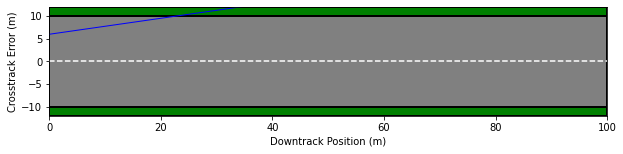

In [66]:
# Get the plot of the road
fig, ax = plot_road()
# Plot the trajectory on the road
ax.plot(dtp_history - START_DTP, cte_history, 'b', linewidth=1)
# Add axis labels
ax.set_xlabel('Downtrack Position (m)')
ax.set_ylabel('Crosstrack Error (m)')
# Display the plot
plt.show()

## Tune the controller

Of course, we don't want our aircraft to drive off the runway, but not to worry. With a little tuning of our control gains, we can fix this! Run the cell below to bring up an interactive plot for tuning the control gains. Slide the `CTE Gain` and `HE Gain` values until you are satisifed with the trajectories your controller produces. You can change the starting crosstrack error to test if your gains work in different scenarios.

In [10]:
def control_interact_func(startCTE, cteGain, heGain):
    # Define the control function based on the gains
    def getControlTuning(client, cte, he):
        return cteGain * cte + heGain * he

    # Simulate the controller
    cte_history, he_history, dtp_history = simulate_controller(client, startCTE, 0.0, 322.0, getState, getControlTuning)

    # Plot the result
    fig, ax = plot_road()
    # Plot the trajectory on the road
    ax.plot(dtp_history - START_DTP, cte_history, 'b', linewidth=1)
    # Add axis labels
    ax.set_xlabel('Downtrack Position (m)')
    ax.set_ylabel('Crosstrack Error (m)')
    # Display the plot
    plt.show()

startCteSlider = widgets.IntSlider(min = -10.0, max = 10.0, step = 1, description = 'Start CTE')
cteGainSlider = widgets.FloatSlider(min = -2.0, max = 2.0, step = 0.01, description = 'CTE Gain')
heGainSlider = widgets.FloatSlider(min = -2.0, max = 2.0, step = 0.01, description = 'HE Gain')

interact(control_interact_func, startCTE = startCteSlider, cteGain = cteGainSlider, heGain = heGainSlider)

interactive(children=(IntSlider(value=0, description='Start CTE', max=10, min=-10), FloatSlider(value=0.0, des…

<function __main__.control_interact_func(startCTE, cteGain, heGain)>

### Put in your new control gains

Let's redo the function below with the control gains you found!

In [14]:
def getControl(client, cte, he):
    """ Returns steering angle command using proportional control
        Args:
            client: XPlane Client
            cte: current estimate of the crosstrack error, x (meters)
            he: current estimate of the heading error, theta (degrees)
    """
    # STUDENT CODE START #cte =10
    cte_gain = -1.68
    he_gain = -0.83 #-1.54
    # return the steering input
    return cte_gain * cte + he_gain * he

    # STUDENT CODE END

    

### Run a single simulation
The line below will run a single simulation (with X-Plane 11) and store the results in arrays called `cte_history`, `he_history`, and `dtp_history`. Run this cell now to watch your controller in action! It will pause for 5 seconds and then run for 20 seconds.

In [15]:
cte_history, he_history, dtp_history = simulate_controller(client, 6.0, 10.0, START_DTP, getState, getControl, useXPlane = True)

### Plot the results

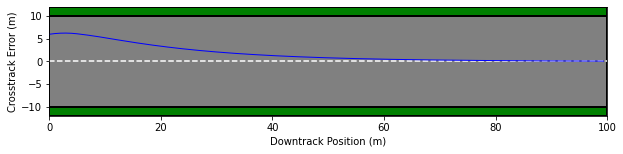

In [16]:
# Get the plot of the road
fig, ax = plot_road()
# Plot the trajectory on the road
ax.plot(dtp_history - START_DTP, cte_history, 'b', linewidth=1)
# Add axis labels
ax.set_xlabel('Downtrack Position (m)')
ax.set_ylabel('Crosstrack Error (m)')
# Display the plot
plt.show()

Everything should look much better now!

### Run many simulations

Now that we have confirmed that our controller is working as intended for one scenario, let's test out some other scenarios. It is important that we make sure our controller will work in many different scenarios. To test this, your next task is to write some code to find the trajectory of the aircraft from a number of starting crosstrack errors by filling in the code cells below.

First, let's initialize some lists to store our outputs:

In [17]:
cte_histories = []
he_histories = []
dtp_histories = []

from tensorflow.keras.models import load_model

In [21]:
taxinet = load_model("Taxinet.h5")

Next, let's call our simulation function from a number of ctes and append the resuts to our lists:

In [26]:
start_ctes = [-8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0]

cte_histories = []
he_histories = []
dtp_histories = []

for start_cte in start_ctes:
    # Simulate the trajectory and get the results
    cte_history, he_history, dtp_history = simulate_controller(client, start_cte, 0.0, START_DTP, getState, getControl)
    # Append to the lists
    cte_histories.append(cte_history)
    he_histories.append(he_history)
    dtp_histories.append(dtp_history)


Finally, let's plot the results! Our goal is to generate a plot similar to the one above for the single trajectory but with all of the trajectories we tested on it. You can use similar code to the plotting code used for the single trajectory. For this case, instead of adding a single trajectory, you will want to loop through the histories and add each trajectory to the plot.

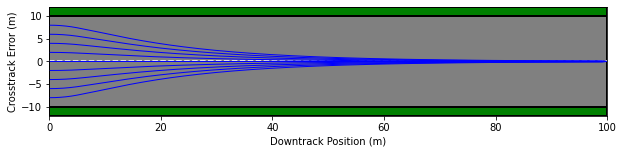

In [25]:
# Get the plot of the road
fig, ax = plot_road()
# Plot the trajectory on the road
for dtp_history, cte_history in zip(dtp_histories, cte_histories):
    ax.plot(dtp_history - START_DTP, cte_history, 'b', linewidth=1)
# Add axis labels
ax.set_xlabel('Downtrack Position (m)')
ax.set_ylabel('Crosstrack Error (m)')
# Display the plot
plt.show()